In [32]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
df = pd.read_csv("amazon_reviews.csv")

def label_sentiment(rating):
    if rating >= 4:
        return 2  # Positive
    elif rating == 3:
        return 1  # Neutral
    else:
        return 0  # Negative

df["label"] = df["overall"].apply(label_sentiment)
df = df.dropna(subset=["reviewText"])


In [34]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["reviewText"].tolist(), df["label"].tolist(),
    test_size=0.2, stratify=df["label"], random_state=42
)

In [35]:
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels}).map(tokenize, batched=True)
test_dataset  = Dataset.from_dict({"text": test_texts, "label": test_labels}).map(tokenize, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/3931 [00:00<?, ? examples/s]

Map:   0%|          | 0/983 [00:00<?, ? examples/s]

In [36]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 54.5 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.4
    Uninstalling tokenizers-0.21.4:
      Successfully uninstalled tokenizers-0.21.4
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.4
    Uninstalling transformers-4.55.4:
      Successfully uninstalled transformers-4.55.4


In [43]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    save_steps=500,
    eval_steps=500,
    save_total_limit=1
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-7041561.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,0.326200
200,0.218600


TrainOutput(global_step=246, training_loss=0.260473321123821, metrics={'train_runtime': 2645.9592, 'train_samples_per_second': 1.486, 'train_steps_per_second': 0.093, 'total_flos': 130184657646336.0, 'train_loss': 0.260473321123821, 'epoch': 1.0})

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



=== DistilBERT Performance ===
              precision    recall  f1-score   support

    Negative       0.67      0.72      0.70        65
     Neutral       0.00      0.00      0.00        28
    Positive       0.96      0.99      0.97       890

    accuracy                           0.94       983
   macro avg       0.54      0.57      0.56       983
weighted avg       0.91      0.94      0.93       983



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


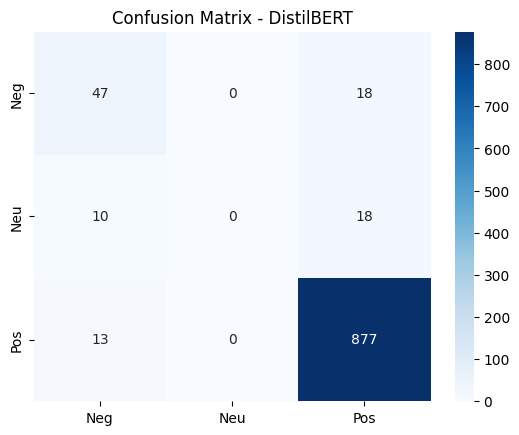

In [44]:
preds = trainer.predict(test_dataset)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

print("\n=== DistilBERT Performance ===")
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=["Neg","Neu","Pos"], yticklabels=["Neg","Neu","Pos"])
plt.title("Confusion Matrix - DistilBERT")
plt.show()

In [45]:
trainer.save_model("./sentiment_model_hf")
tokenizer.save_pretrained("./sentiment_model_hf")

('./sentiment_model_hf/tokenizer_config.json',
 './sentiment_model_hf/special_tokens_map.json',
 './sentiment_model_hf/vocab.txt',
 './sentiment_model_hf/added_tokens.json',
 './sentiment_model_hf/tokenizer.json')